In [17]:
import pandas as pd
import os.path
from core.util.math import compute_ft

from user_scripts.Timo.own.console_toolkit import Tk_file, Tk_string

In [44]:
Tk_file.list_mult_pulsed_mes

Traceback (most recent call last):
  File "C:\Users\Setup3-PC\Desktop\qudi\logic\jupyterkernel\qzmqkernel.py", line 679, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-44-5980357fb518>", line 1, in <module>
    Tk_file.list_mult_pulsed_mes
AttributeError: type object 'Tk_file' has no attribute 'list_mult_pulsed_mes'


In [653]:
def tk_file_list_mult_pulsed_mes(path, incl_subdir=True, filter_strs=['pulsed_measurement', '.dat'],
                             excl_filter_str=None, excl_params=['']):
    
    files = Tk_file.get_dir_items(path, incl_subdir=incl_subdir)
    files_filtered = files
    for f_str in filter_strs:
        files_filtered = Tk_string.filter_str(files_filtered, f_str, excl_filter_str)

    return files_filtered

def load_pulsed_result(fname):
    """
    shaddows analysis snippets
    """

    mes = pd.read_csv(fname, sep="\t", comment='#', names=["tau", "z1", "z2", "std1", "std2"])

    return mes

def setup_clear_plots(n_plots):
    n_cur = qdplotlogic.number_of_plots
    for i in range(n_cur):
        n_cur_i = qdplotlogic.number_of_plots
        if n_cur_i >= 1:
            # removing without arguments seems buggy
            qdplotlogic.remove_plot(n_cur_i-1)
    
    for i in range(n_plots):
        qdplotlogic.add_plot()
def extract_num_from_path(file):
    fname = os.path.basename(file)
    res = Tk_string.find_num_in_str(fname)
    
    return res

"""
# delete if Tk_file import works
def load_pulsed_result(fname):

    data = pd.read_csv(fname, sep="\t", comment='#', names=["tau", "z1", "z2", "std1", "std2"])
    if pd.isnull(data.iloc[0, -1]):
        data = pd.read_csv(fname, sep="\t", comment='#', names=["tau", "z1", "std1"])
    meta = Tk_file.load_pulsed_metadata(fname)

    mes = {'data': data,
           'file': fname}
    mes = {**mes, **meta}

    return mes
"""
def do_fit(p_mes, fit_y='delta', fit_method='sine'):
    fitter = pulsedmeasurementlogic.fc
    fitter.set_current_fit(fit_method)
    """
    x_fit, y_fit, result = fitter.do_fit(data[0], data[1])
    result = result.result_str_dict

    result['Position']['value']
    result['FWHM']['value']
    result['Contrast']['value']
    """

    if fit_y == 'delta':
        data = np.asarray(p_mes['data']['tau']), np.asarray(delta_or_z1(p_mes))
    elif fit_y == 'z1':
        data = np.asarray(p_mes['data']['tau']), np.asarray(p_mes['data']['z1'])
    else:
        raise ValueError

    x_fit, y_fit, result = fitter.do_fit(data[0], data[1])
    result = result.result_str_dict
    p_mes['fit_res'] = result


def get_z(p_mes, mode='z1'):
    # mode: z1, z2, delta, (+_norm)
    try:
        has_z2 = True
        try:
            p_mes['data']['z2']
        except KeyError:
            has_z2 = False
            
        tau = p_mes['data']['tau']
        z1 = p_mes['data']['z1']
        z1_norm = z1/np.average(z1)
        
        if mode == 'z1':
            return z1
        elif mode == 'z1_norm':
            return z1_norm
        elif mode == 'z2' or mode == 'z2_norm' or mode=='delta' or mode=='delta_norm':
            if has_z2:
                z2 = p_mes['data']['z2']
                delta = (z1-z2)
                delta_norm = delta/np.average(z1)
            else:
                raise KeyError
                
            if mode == 'z2':
                return z2
            if mode == 'z2_norm':
                return z2/np.average(z2)
            if mode == 'delta':
                return delta
            if mode == 'delta_norm':
                return delta_norm
        else:
            raise ValueError(f"Unknown mode: {mode}")  

    except:
        logger.exception(f"Loading of {mode} from file {p_mes['file']} failed")
        raise  

def delta_or_z1(p_mes, norm=False):
    try:
        has_z2 = True
        try:
            p_mes['data']['z2']
        except KeyError:
            has_z2 = False

        tau = p_mes['data']['tau']
        z1 = p_mes['data']['z1']
        z1_norm = z1/np.average(z1)

        if has_z2:
            z2 = p_mes['data']['z2']
            delta = (z1-z2)
            delta_norm = delta/np.average(z1)

            if norm:
                return delta_norm
            else:
                return delta

        if norm:
            return z1
        return z1_norm
    except:
        logger.exception(f"Loading of file {p_mes['file']} failed")
        raise
        


def pulsed_series_2_array(pulsed_series, idx_var_y=None, ordered_y=True):
    y2d = []
    z1s, z2s = [], []
    x2d = []

    for p in p_raw:
        try:
            z1 = p['data']['z1']
            try:
                z2 = p['data']['z2']
            except:
                z2 = None
            # set x axis of 2d plot
            tau = p['data']['tau']
            # set y axis of 2d plot
            idx_file = extract_num_from_path(p['file'])[-2]
            if idx_var_y != None:
                var_file = float(extract_num_from_path(p['file'])[idx_var_y])
            # set y axis as time of mes
            if idx_var_y == None:
                var_file = p['date'].timestamp() - p_raw[0]['date'].timestamp()
            #logger.info(f"1st: tau {tau}, x2d {x2d}")
            if len(x2d) > 0:
                err = f"Data in file {p['file']} doesn't share tau axis"
                try:
                    if not np.all(x2d == tau):
                        raise ValueError(err)
                except:
                    logger.exception(err)
                    raise


            x2d = tau
            #logger.info(f"tau {tau}, x2d {x2d}")
            y2d.append(var_file)
            z1s.append(z1)
            z2s.append(z2)
        except:
            logger.exception(f"Loading of file {p['file']} failed")
            raise



    z1s = np.asarray(z1s)
    z2s = np.asarray(z2s)

    x2d = np.asarray(x2d)
    y2d = np.asarray(y2d)
    
    if ordered_y:
        y2d,  z1s, z2s = np.sort(y2d), z1s[y2d.argsort()], z2s[y2d.argsort()]
    
    return x2d, y2d, z1s, z2s


def pulsed_series_2_1d_fit_array(pulsed_series, fit_meth, fit_on, fit_vals,
                                 idx_var_x=None, ordered_x=True):
    
    x,y, y2, y3 = [], [], [], []
    dy = []
    
    for p in pulsed_series:
        try:
            # set x axis of 1d plot
            # idx_file = extract_num_from_path(p['file'])[-2]
            if idx_var_x:
                var_file = float(extract_num_from_path(p['file'])[idx_var_x])
            # set y axis as time of mes
            else:
                var_file = p['date'].timestamp() - p_raw[0]['date'].timestamp()
            x.append(var_file)

            # fit result on y axis
            do_fit(p, fit_y=fit_on, fit_method=fit_meth)

            y.append(_get_fit(p, 0, error=False, cust_vals=fit_vals))
            dy.append(_get_fit(p, 0, error=True, cust_vals=fit_vals))
            y2.append(_get_fit(p, 1, error=False, cust_vals=fit_vals))
            y3.append(_get_fit(p, 2, error=False, cust_vals=fit_vals))


        except:
            logger.exception(f"Loading of file {p['file']} failed")
            raise

    x, y, y2, y3, dy = np.asarray(x), np.asarray(y), np.asarray(y2),  np.asarray(y3), np.asarray(dy)
    if ordered_x:
        x, y, y2, y3, dy = np.sort(x), y[x.argsort()], y2[x.argsort()], y3[x.argsort()], dy[x.argsort()]
    
    return x, y, y2, y3, dy

def _get_fit(p, y_idx=0, error=False, cust_vals=None):
    fit_vals = ['Lifetime', 'Contrast', 'Frequency']
    if cust_vals:
        fit_vals = cust_vals
    fit_quant = 'value'
    if error:
        fit_quant = 'error'
    try:
        return p['fit_res'][fit_vals[y_idx]][fit_quant]
    except:
        return -1


# Load qudi pulsed data

In [194]:
fname = r"E:\Data\2021\06\20210622\PulsedMeasurement" + "\\" \
        + "20210622-1350-12_ramsey_deer_pi_df=3MHz_two_deer_pi_OffRes_pulsed_measurement.dat"

fname = os.path.normpath(fname)
p_data = load_pulsed_result(fname)
0

0

# Plot in qudi plot

Need to activate qdplotgui first!

## Alternating: z1,z2; Delta (z1-z2); FFT(Delta) trace

In [349]:
x = np.asarray(p_data['tau'])
z1 =  np.asarray(p_data['z1'])
z2 = np.asarray(p_data['z2'])
fft_x, fft_delta = compute_ft(x_val=x,
                          y_val=z1-z2)

qdplotlogic.set_data(x, z1)
qdplotlogic.set_data(x, z2, clear_old=False)

qdplotlogic.set_data(x, z1-z2, plot_index=1)

qdplotlogic.set_data(fft_x, fft_delta, plot_index=2)


0

## Double alternating

Four z per tau [(tau_i, tau_i, tau_i, tau_i), (tau_i+1, tau_i+1, ...), ..]:


    tau_i_1: normal        | -> z1  
    tau_i_2: normal 3pi2   |
    tau_i_3: no DEER pi    | -> z2
    tau_i_4: no DEER 3pi2  |




In [197]:
x = np.asarray(p_data['tau'])[::2]
z_raw_1 =  np.asarray(p_data['z1'])   # tau_i_1, tau_i_3
z_raw_2 = np.asarray(p_data['z2'])    # tau_i_2, tau_i_4
delta_raw = z_raw_1-z_raw_2
z1 = delta_raw[::2]  # deer
z2 = delta_raw[1::2] # no deer
delta = z1-z2

fft_x, fft_z1 = compute_ft(x_val=x,
                          y_val=z1)
fft_x, fft_z2 = compute_ft(x_val=x,
                          y_val=z2)

setup_clear_plots(3)

#qdplotlogic.set_data(x, z1)
#qdplotlogic.set_data(x, z2, clear_old=False)
#qdplotlogic.set_title("Z1: DEER, Z2: no DEER")

qdplotlogic.set_data(x, z2)
qdplotlogic.set_data(x, z1, clear_old=False)
qdplotlogic.set_title("Z1: no DEER, Z2: DEER")

qdplotlogic.set_data(fft_x, fft_z1, plot_index=1)
qdplotlogic.set_title("FFT(DEER)", plot_index=1)
qdplotlogic.set_data(fft_x, fft_z2, plot_index=2)
qdplotlogic.set_title("FFT(no DEER)", plot_index=2)
0

0

### Single z1, z2 for deer, no deer

In [185]:
detail_nodeer_plot = False
detail_deer_plot = not detail_nodeer_plot

# plot pi2, 3pi2: DEER
z_deer = z_raw_1[::2]
z_deer_3pi2 = z_raw_2[::2]

#  plot pi2, 3pi2: no DEER
z_nodeer = z_raw_1[1::2]
z_nodeer_3pi2 = z_raw_2[1::2]

if detail_deer_plot:
    z1 = z_deer
    z2 = z_deer_3pi2
if detail_nodeer_plot:
    z1 = z_nodeer
    z2 = z_nodeer_3pi2

setup_clear_plots(5)
    
qdplotlogic.set_data(x, z1)
qdplotlogic.set_data(x, z2, clear_old=False)
qdplotlogic.set_title("Z1: pi2 read, Z2: 3pi2 read")
qdplotlogic.set_data(x, z1-z2, plot_index=1)
qdplotlogic.set_title("Delta: Z1-Z2", plot_index=1)

fft_x, fft_z1 = compute_ft(x_val=x,
                          y_val=z1)
fft_x, fft_z2 = compute_ft(x_val=x,
                          y_val=z2)
fft_x, fft_delta = compute_ft(x_val=x,
                          y_val=z1-z2)

qdplotlogic.set_data(fft_x, fft_z1, plot_index=2)
qdplotlogic.set_title("FFT(Z1)", plot_index=2)
qdplotlogic.set_data(fft_x, fft_z2, plot_index=3)
qdplotlogic.set_title("FFT(Z2)", plot_index=3)
qdplotlogic.set_data(fft_x, fft_delta, plot_index=4)
qdplotlogic.set_title("FFT(Z1-Z2)", plot_index=4)

# Qudi data series

## Load from subfolders

In [1406]:
p_raw, x, y, fnames = [], [], [], []

inpath = r"E:\Data\2021\11\20211102\PulsedMeasurement\ise_vs_ampl_1"
#inpath = r"E:\Data\2021\10\20211026\PulsedMeasurement\rnovel_vs_p_1"

filter_strs = ['pulsed_measurement', '.dat']
#filter_strs += ['pulsedodmr']

fnames = tk_file_list_mult_pulsed_mes(inpath, filter_strs=filter_strs, incl_subdir=True)


for f in fnames:
    #p_i = Tk_file.load_pulsed_metadata(f)
    #p_i = {**p_i, **{'file': f, 'data':Tk_file.load_pulsed_result(f)['data']}}
    #p_i = Tk_file.load_pulsed_result(f)
    p_i = Tk_file.load_pulsed_result(f)
    p_raw.append(p_i)

data = load_pulsed_result(p_raw[1]['file'])


In [1058]:
p_raw[-1]['date'], len(fnames)

(Timestamp('2021-10-29 14:59:02'), 11)

## Load 2d data series

In [1568]:
p_raw, x, y, fnames = [], [], [], []

inpath = r"E:\Data\2021\11\20211102\PulsedMeasurement\ise_vs_sweepSpeed_1"

fnames = tk_file_list_mult_pulsed_mes(inpath, incl_subdir=False)

for f in fnames:
    #p_i = Tk_file.load_pulsed_metadata(f)
    #p_i = {**p_i, **{'file': f, 'data':Tk_file.load_pulsed_result(f)['data']}}
    #p_i = Tk_file.load_pulsed_result(f)
    p_i = Tk_file.load_pulsed_result(f)
    p_raw.append(p_i)

data = load_pulsed_result(p_raw[1]['file'])
#Put onto 2d grid: Every row a single pulsed result
x, y, z1s, z2s = pulsed_series_2_array(p_raw, idx_var_y=-1, ordered_y=True)
p_raw[-1]['file']

'E:\\Data\\2021\\11\\20211102\\PulsedMeasurement\\ise_vs_sweepSpeed_1/20211102-1520-36_ise_propi_idx=14_sweepspeed=0.010MHz_us_pulsed_measurement.dat'

In [1550]:
y

array([0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11, 0.12,
       0.13, 0.14, 0.15])

In [554]:
p_raw[-1]['date'], p_raw[0]['date']

## Plot multiple 1d

In [662]:
#get_z(p_raw[0], mode='delta')

In [794]:
plot_mode = "delta_norm"
offset = 0.05

for i, mes in enumerate(p_raw):
    x_i = mes['data']['tau']
    y_i = offset*i + get_z(mes, mode=plot_mode)
    plt.plot(x_i, y_i)
    
plt.show()

Traceback (most recent call last):
  File "C:\Users\Setup3-PC\Desktop\qudi\logic\jupyterkernel\qzmqkernel.py", line 679, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-794-4705281fbfab>", line 6, in <module>
    y_i = offset*i + get_z(mes, mode=plot_mode)
  File "<ipython-input-653-624d49440192>", line 98, in get_z
    raise KeyError
KeyError


## Plot 2d color map

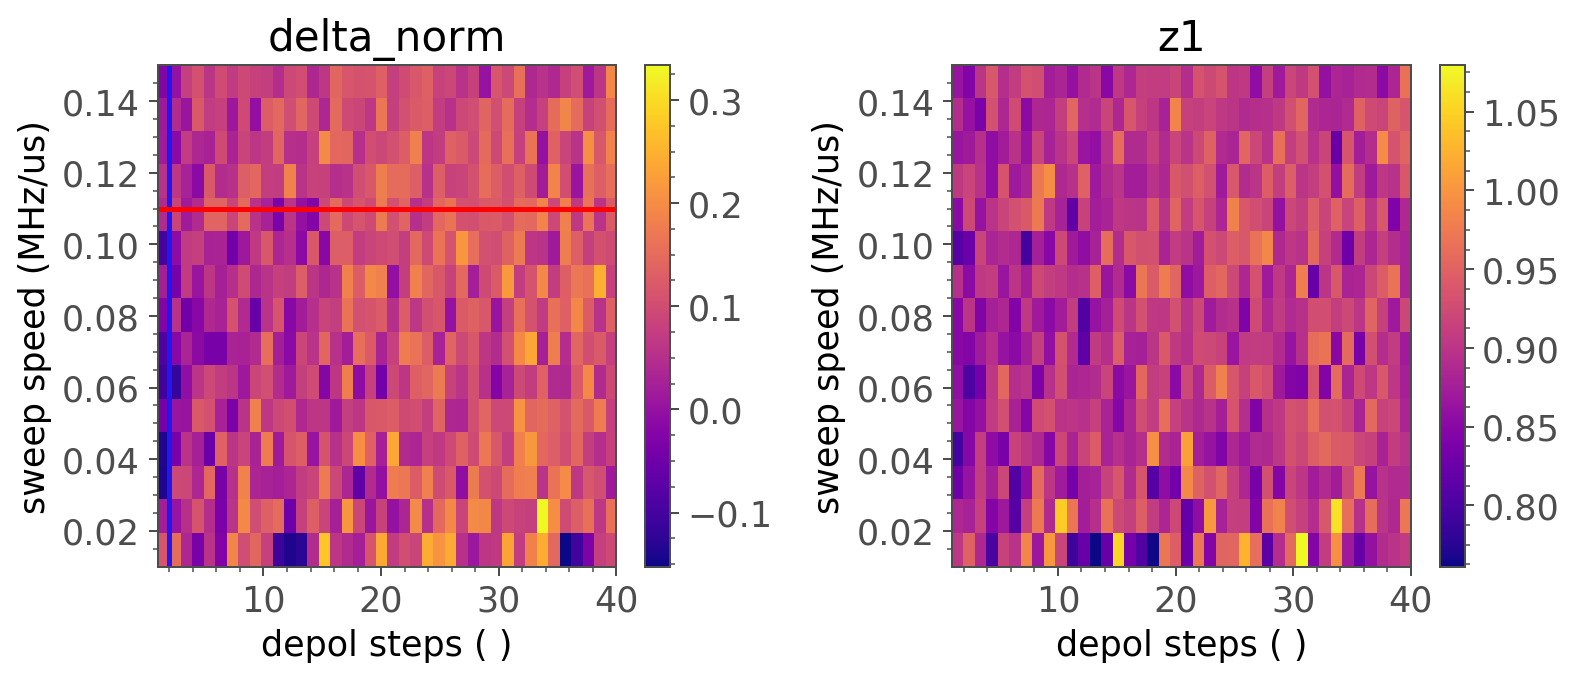

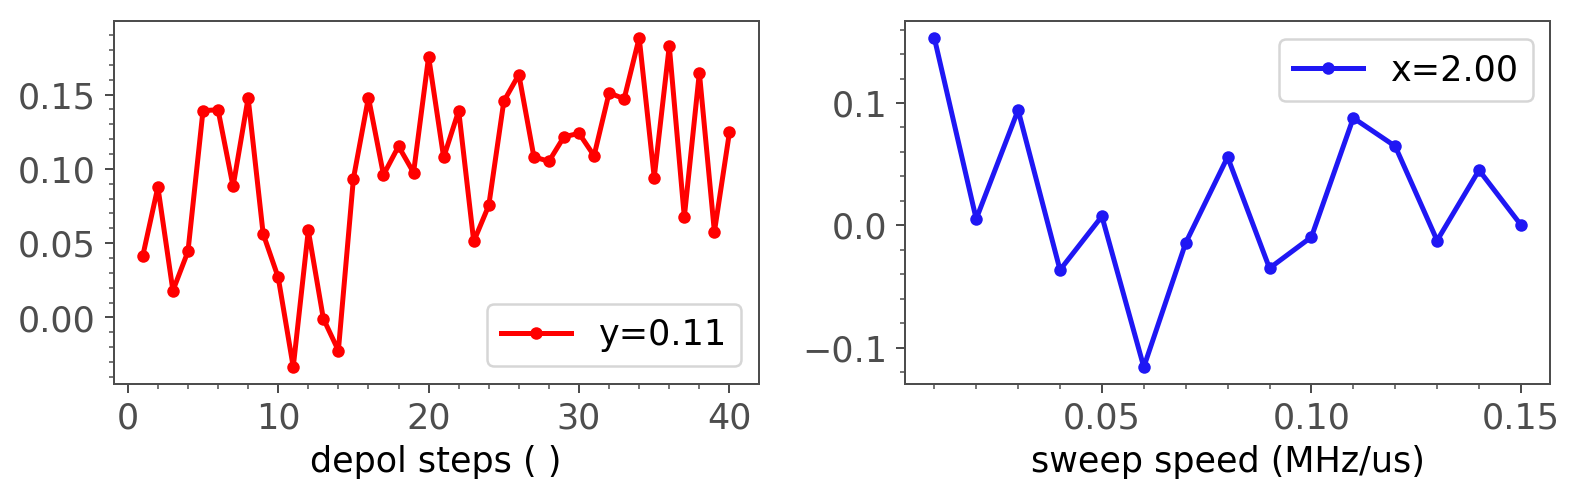

In [1571]:
scale_fac = [1e6, 1]
scale_fac = [1, 1]
#scale_fac = [1e-6, 1]
extent = [x[0]*scale_fac[0], x[-1]*scale_fac[0], y[0]*scale_fac[1], y[-1]*scale_fac[1]]
#plot_labels = ["t (us)", "ise ampl (mV)"]
#plot_labels = ["f (MHz)", "time (s)"]
plot_labels = ["depol steps ( )", "ampl (mV)"]
#plot_labels = ["depol steps ( )", "df (MHz)"]
plot_labels = ["depol steps ( )", "sweep speed (MHz/us)"]
#plot_labels = ["depol steps ( )", "dd order (mV)"]


idx_cut_y = 10
idx_cut_x = 1
cut_mode = "delta_norm"
#cut_mode = "z1"

try:
    x[idx_cut_x]
except IndexError:
    idx_cut_x = 0
try:
    y[idx_cut_y]
except IndexError:
    idx_cut_y = 0

if z2s[0,0] != None:
    delta_norm = (z1s-z2s)/np.average(z1s, axis=1)[:,None]
    z1_norm = (z1s)/np.average(z1s, axis=1)[:,None]
    z2_norm = (z2s)/np.average(z2s, axis=1)[:,None]
    plot_mode = "delta_norm"
else:
    z1_norm = (z1s)/np.average(z1s, axis=1)[:,None]
    delta_norm = z1_norm
    plot_mode = "z1_norm"

#plt.figure(figsize=(5,3.5))

plt.figure(figsize=(9,4))
plt.subplot(121)
plt.title(f"{plot_mode}")
plt.imshow(delta_norm, 
           extent=extent, aspect='auto', origin='lower', cmap="plasma"
          #,vmin=0.14
          #,vmax=0.2
          )

if cut_mode == "delta_norm":
    plt.axvline(x[idx_cut_x]*scale_fac[0])
    plt.axhline(y[idx_cut_y]*scale_fac[1], color='red')
plt.xlabel(plot_labels[0])
plt.ylabel(plot_labels[1])
plt.colorbar()


#plt.ylim(6.6,10)

plt.subplot(122)
plt.title("z1")
plt.imshow(z1s, 
           extent=extent, aspect='auto', origin='lower', cmap="plasma"
          #,vmin=0.85
          )

if cut_mode == "z1":
    plt.axvline(x[idx_cut_x]*scale_fac[0])
    plt.axhline(y[idx_cut_y]*scale_fac[1], color='red')
plt.xlabel(plot_labels[0])
plt.ylabel(plot_labels[1])
plt.colorbar()


plt.tight_layout()
plt.show()

# plot cuts
if cut_mode == "delta_norm":
    zcut = delta_norm
else:
    zcut = z1s
    
plt.figure(figsize=(9,3))
plt.subplot(121)
plt.plot(x*scale_fac[0], zcut[idx_cut_y,:], label=f"y={y[idx_cut_y]*scale_fac[1]:.2f}", color='red')
plt.xlabel(plot_labels[0])
plt.legend()

plt.subplot(122)
plt.plot(y*scale_fac[1], zcut[:,idx_cut_x], label=f"x={x[idx_cut_x]*scale_fac[0]:.2f}")
plt.xlabel(plot_labels[1])
plt.legend()



plt.tight_layout()
plt.show()

### FFT analysis

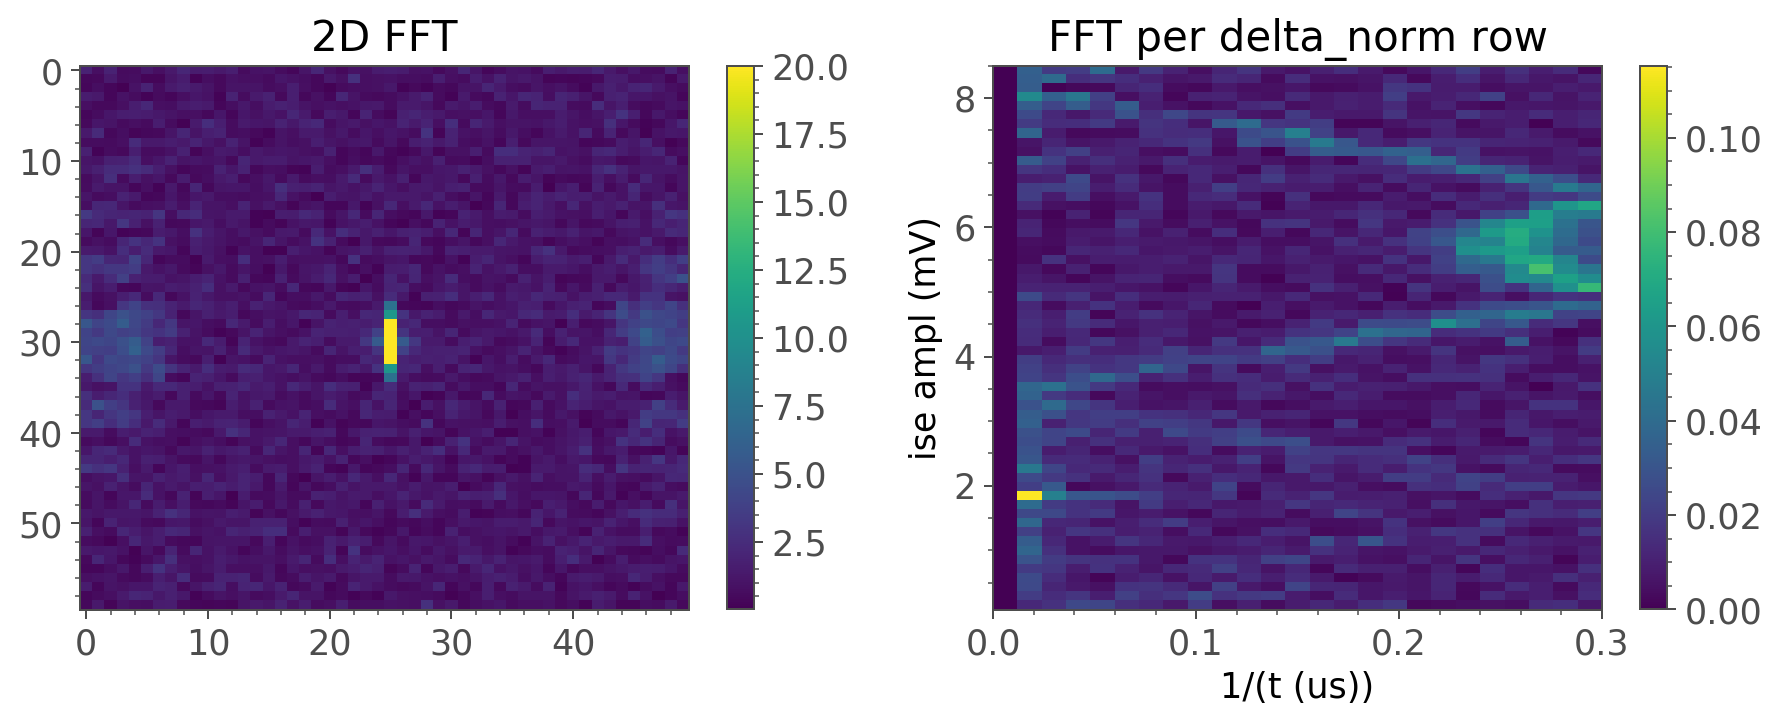

In [88]:
plt.figure(figsize=(12,4))
plt.subplot(121)
# 2d fft
ftimage = np.fft.fft2(z1s)
ftimage = np.fft.fftshift(ftimage)
plt.title("2D FFT")
plt.imshow(np.abs(ftimage), vmax=20, aspect='auto')
plt.colorbar()

# fft per line
fft_rows = []
fft_x = None

if cut_mode == "delta_norm":
    zs = delta_norm
elif cut_mode == 'z1':
    zs = z1s
for idx_row, row in enumerate(zs):
    fft_x, fft_delta = compute_ft(x_val=x, y_val=row)
    fft_rows.append(fft_delta)

plt.subplot(122)
plt.title(f"FFT per {cut_mode} row")
extent = [fft_x[0]/scale_fac[0], fft_x[-1]/scale_fac[0], y[0]*scale_fac[1], y[-1]*scale_fac[1]]
plt.imshow(fft_rows, origin='lower', extent=extent, aspect='auto'
          #,vmax=0.05
          #,vmin=0.01
          )
#plt.xlim([0,0.8])
plt.ylabel(plot_labels[1])
plt.xlabel(f"1/({plot_labels[0]})")
plt.colorbar()
plt.show()

In [659]:
len(row)

35

## Fit on series

In [1574]:


y_val_idx = -1
x_val = "ampl"
x_unit = "mV"
scale_fac_x = [1]
scale_fac_y = [1e6, 1e-6, 1e-6]
fit_on = 'delta'
fit_meth = 'sine_2x'
fit_vals = ['Lifetime', 'Frequency 1', 'Frequency 2']
fit_units = ['us','MHz', 'MHz']
calc_dxdy_fromto = [(0,-1), (1,-1), False]

"""
y_val_idx = None
x_val = "Time"
x_unit = "min"
scale_fac_x = [1/60.]
scale_fac_y = [1e-6, 1e6, 1e-6]
fit_on = 'z1'
fit_meth = 'lor_dip'
fit_vals = ['Position', 'Lifetime', 'Frequency 2']
fit_units = ['MHz','us', 'MHz']
"""
"""
y_val_idx = -1
x_val = "ampl"
x_unit = "mV"
scale_fac_x = [1]
scale_fac_y = [1e6, 1e-6, 1e-6]
fit_on = 'delta'
fit_meth = 'sine'
fit_vals = ['Lifetime', 'Frequency', 'Frequency 2']
fit_units = ['us','MHz', 'MHz']
"""
#"""
y_val_idx = -1
x_val = "ampl"
x_unit = "mV"
x_val = "sweep speed"
x_unit = "MHz/us"
scale_fac_x = [1]
scale_fac_y = [1, 1, 1e-6]
fit_on = 'delta'
fit_meth = 'decay_exp'
fit_vals = ['Amplitude', 'Lifetime', 'Frequency 2']
fit_units = ['','steps', 'MHz']
calc_dxdy_fromto = [(0,-1), False, False]
#"""

#scale_fac_x = [1e-3]
#scale_fac_y = [1e6, 1e-6, 1e-6]
#x_val = "df"
#x_unit = "kHz"
"""
y_val_idx = None
x_val = "Time"
x_unit = "s"
scale_fac_x = [1e-6]
scale_fac_y = [1e-6, 1e-6, 1e-6]
fit_on = 'delta'
fit_meth = 'lor_peak_2x'
fit_vals = ['Position 0', 'Position 1', 'None']
fit_units = ['MHz','MHz', 'MHz']
"""
"""
y_val_idx = 3
x_val = "idx"
x_unit = ""
scale_fac_x = [1]
scale_fac_y = [1e9, 1e-6, 1e-6]
fit_on = 'delta'
fit_meth = 'decay_exp'
fit_vals = ['Lifetime', 'Position 1', 'None']
fit_units = ['ns','MHz', 'MHz']
"""


'\ny_val_idx = 3\nx_val = "idx"\nx_unit = ""\nscale_fac_x = [1]\nscale_fac_y = [1e9, 1e-6, 1e-6]\nfit_on = \'delta\'\nfit_meth = \'decay_exp\'\nfit_vals = [\'Lifetime\', \'Position 1\', \'None\']\nfit_units = [\'ns\',\'MHz\', \'MHz\']\n'

In [1577]:
x, y, y2, y3, dy = pulsed_series_2_1d_fit_array(p_raw, 
                                                fit_meth=fit_meth, fit_on=fit_on, fit_vals=fit_vals,
                                                idx_var_x=y_val_idx, ordered_x=True)
y/1e6

array([ 7.35085842e-08, -9.85060797e-08, -1.09176709e-07, -2.43070795e-07,
       -1.11757013e-07, -1.28330514e-07, -1.78313923e-07, -1.31214046e-07,
       -1.28857016e-07, -1.51506909e-07, -1.33900101e-07, -8.17504396e-08,
       -1.17799771e-07, -9.15543456e-08, -5.83059200e-08])

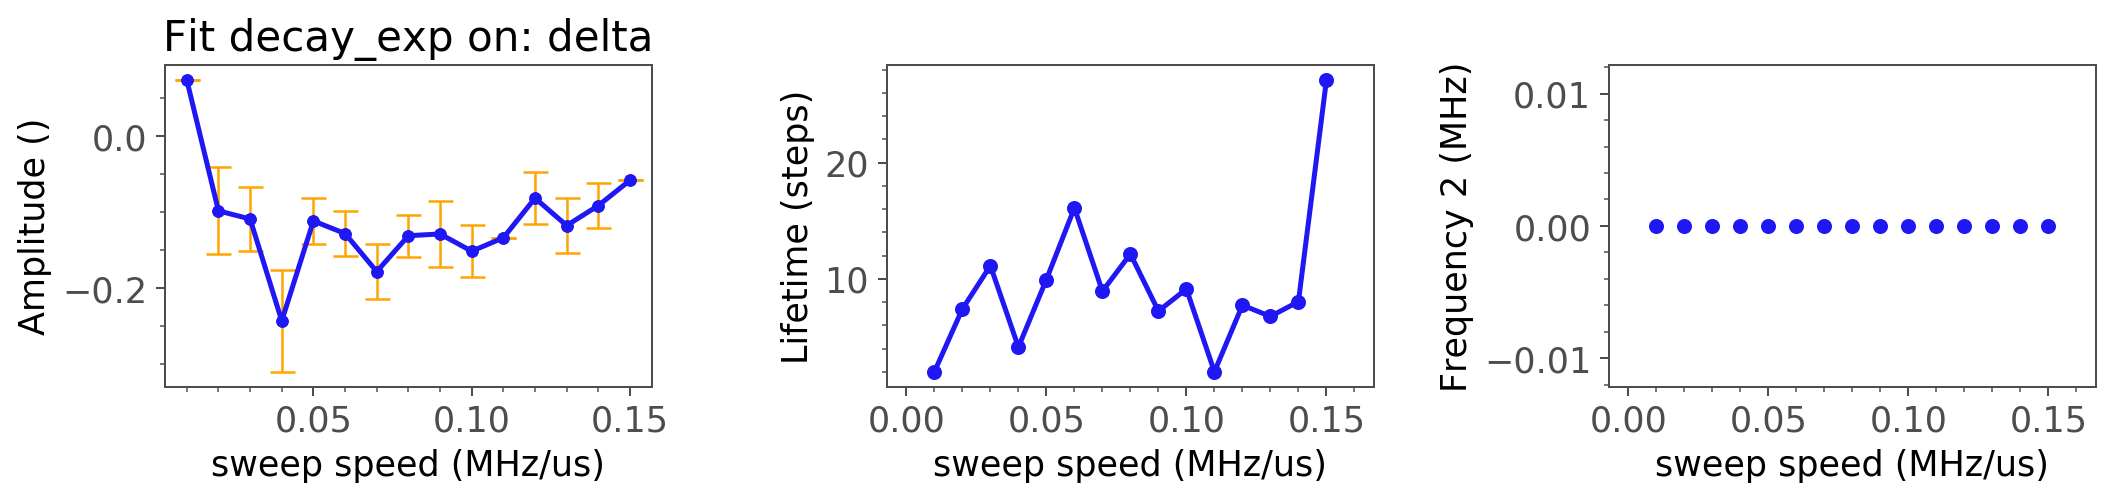

In [1580]:
plt.figure(figsize=(12,3))


plt.subplot(131)

#plt.scatter(x,1e6*y)
try:
    #raise  # don't plot errorbar
    plt.errorbar(scale_fac_x[0]*x,scale_fac_y[0]*y, 
                yerr=scale_fac_y[0]*dy,
                 ecolor='orange', capsize=5, fmt='o', elinewidth=1, capthick=1)
    y_min = np.min(scale_fac_y[0]*y)
    y_max = np.max(scale_fac_y[0]*y)
    #plt.ylim([y_min-abs(0.1*y_min), y_max+abs(0.1*y_max)])
    
except:
    plt.scatter(scale_fac_x[0]*x,scale_fac_y[0]*y)
plt.plot(scale_fac_x[0]*x,scale_fac_y[0]*y)


    
plt.title(f"Fit {fit_meth} on: {fit_on}")
plt.xlabel(f"{x_val} ({x_unit})")
plt.ylabel(f"{fit_vals[0]} ({fit_units[0]})")
#plt.xlabel("Time (s)")
#plt.ylabel("Frequency (MHz)")

#plt.xlim(0.5,2)

plt.subplot(132)
plt.scatter(x,y2*scale_fac_y[1])
plt.plot(x,y2*scale_fac_y[1])
plt.xlabel(f"{x_val} ({x_unit})")
plt.ylabel(f"{fit_vals[1]} ({fit_units[1]})")

if calc_dxdy_fromto[1]:
    idx_slope_from = calc_dxdy_fromto[1][0]
    idx_slope_up_to = calc_dxdy_fromto[1][1]
    dfdx = np.diff(y2)/np.diff(x)
    avg_dfdx = np.average(dfdx[idx_slope_from:idx_slope_up_to])
    y0 = scale_fac_y[1]* (y2[idx_slope_from]-(x[idx_slope_from]-0)*avg_dfdx)
    
    plt.plot([x[idx_slope_from], x[idx_slope_up_to]],
             [ y2[idx_slope_from]*scale_fac_y[1],
              (y2[idx_slope_from]+(x[idx_slope_up_to]-x[idx_slope_from])*avg_dfdx)*scale_fac_y[1]],
             label=f"y= {avg_dfdx*scale_fac_y[1]:.4f}x +{y0:.4f}", marker="", color='red', linewidth=2, alpha=0.7)
    plt.legend()

#plt.ylim(0,10)

plt.subplot(133)
plt.scatter(x,y3*scale_fac_y[2])

if calc_dxdy_fromto[2]:
    idx_slope_from = calc_dxdy_fromto[2][0]
    idx_slope_up_to = calc_dxdy_fromto[2][1]

    dfdx = np.diff(32)/np.diff(x)
    avg_dfdx = np.average(dfdx[idx_slope_from:idx_slope_up_to])
    y0 = scale_fac_y[2]* (y3[idx_slope_from]-(x[idx_slope_from]-0)*avg_dfdx)
    
    plt.plot([x[idx_slope_from], x[idx_slope_up_to]],
             [y3[idx_slope_from]/1e6,(y3[idx_slope_from]+(x[idx_slope_up_to]-x[idx_slope_from])*avg_dfdx)/1e6],
             label=f"y= {avg_dfdx*scale_fac_y[2]:.4f}x + {y0*scale_fac_y[2]:.4f}", marker="")
    plt.legend()
    
plt.xlabel(f"{x_val} ({x_unit})")
plt.ylabel(f"{fit_vals[2]} ({fit_units[2]})")
#plt.ylim(0, 1)

plt.tight_layout()
plt.show()

In [1541]:
x[-1]

0.15

### area of exp decay fit

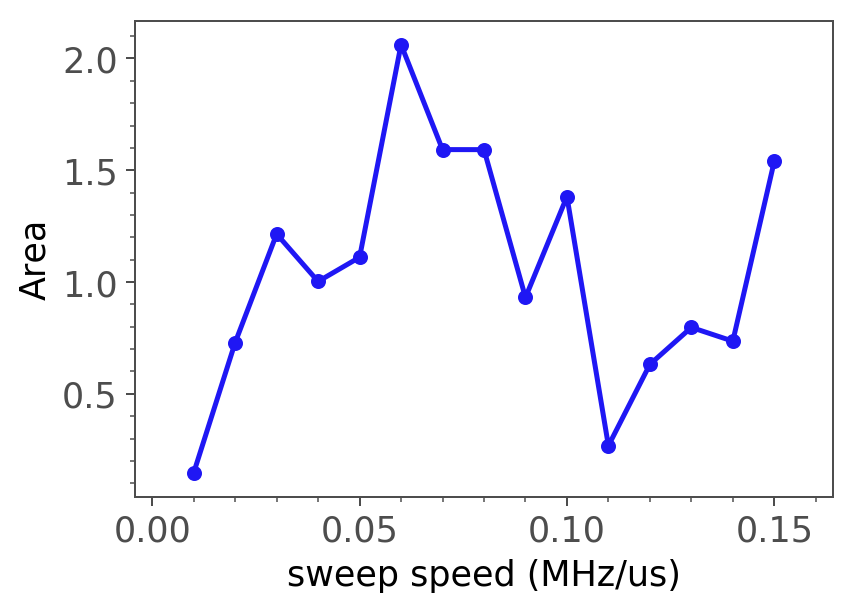

In [1583]:
ampl = scale_fac_y[0]*y
lifetime = scale_fac_y[1]*y2
beta = 1
t_integrate_to = 100

# todo: double check
area = abs(ampl*(lifetime - lifetime/beta*(np.exp(-t_integrate_to/lifetime))**beta))

plt.figure(figsize=(5,3.5))
plt.scatter(x,area)
plt.plot(x,area)
try:
    qdplotlogic.set_data(x, area, clear_old=True)
except: pass
    
plt.ylabel("Area")
plt.xlabel(f"{x_val} ({x_unit})")
plt.show()

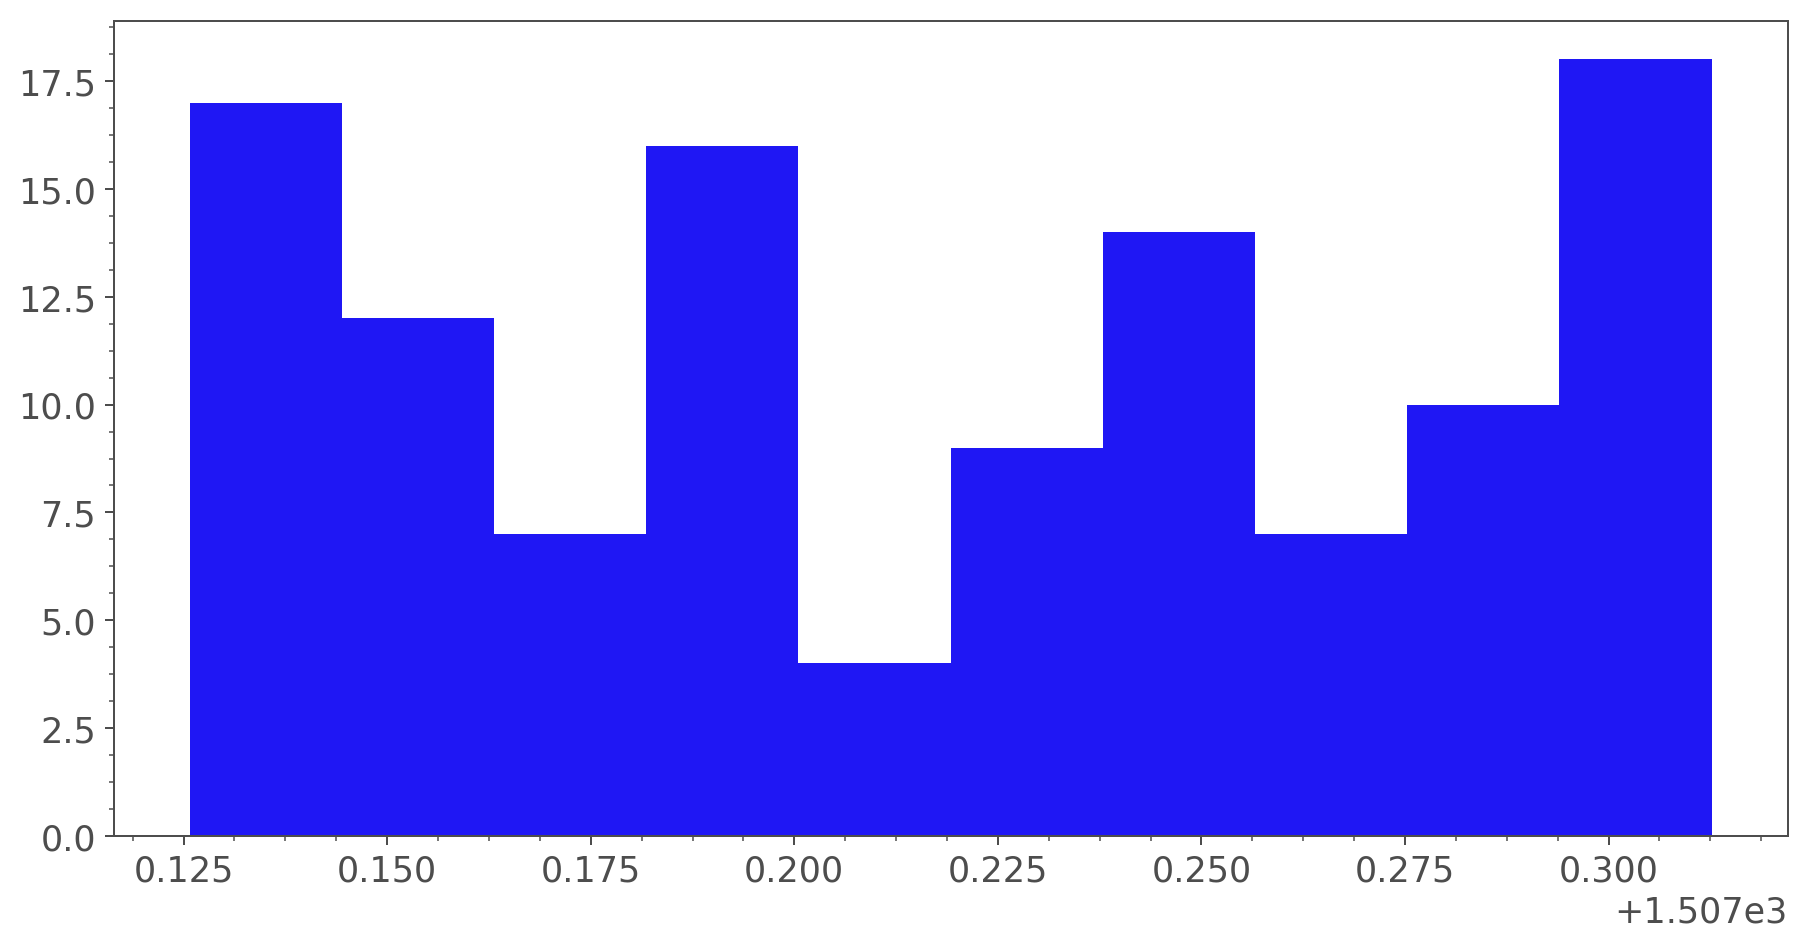

In [584]:
plt.hist(scale_fac_y[0]*y)
plt.show()

## A y cut to qudipolotter

In [1544]:
idx_y_cut = -1

x = np.asarray(p_raw[idx_y_cut]['data']['tau'])
z1 =  np.asarray(p_raw[idx_y_cut]['data']['z1'])
try:
    z2 = np.asarray(p_raw[idx_y_cut]['data']['z2'])
except:
    z2 = np.zeros(p_raw[idx_y_cut]['data']['z1'].shape)
    
fft_x, fft_delta = compute_ft(x_val=x,
                          y_val=z1-z2)

qdplotlogic.set_data(x, z1)
qdplotlogic.set_data(x, z2, clear_old=False)

qdplotlogic.set_data(x, z1-z2, plot_index=1)

qdplotlogic.set_data(fft_x, fft_delta, plot_index=2)


0

In [1520]:
z1

array([0.86345966, 0.84494972, 0.90053644, 0.93888095, 0.89302272,
       0.91005891, 0.93355589, 0.9280039 , 0.87463218, 0.88301416,
       0.86009329, 0.88833256, 0.9002843 , 0.84991304, 0.90509856,
       0.88529944, 0.91075963, 0.91004198, 0.90868121, 0.91804983,
       0.89188202, 0.9345987 , 0.92286065, 0.93478024, 0.90207018,
       0.90565132, 0.85637634, 0.91214815, 0.87036712, 0.91943894,
       0.90633107, 0.93099565, 0.86039172, 0.88363534, 0.87918437,
       0.88923019, 0.89100715, 0.85437369, 0.88416643, 0.96511383])

# Load qudi data series from subbolders

In [137]:
fnames[0:4]

['E:\\Data\\2021\\10\\20211028\\PulsedMeasurement\\rnovel_frefocus_tau=333ns_vs_p_4\\podmr_refocus\\20211028-1322-04_pulsedodmr_shaped_pulsed_measurement.dat', 'E:\\Data\\2021\\10\\20211028\\PulsedMeasurement\\rnovel_frefocus_tau=333ns_vs_p_4\\podmr_refocus\\20211028-1324-51_pulsedodmr_shaped_pulsed_measurement.dat', 'E:\\Data\\2021\\10\\20211028\\PulsedMeasurement\\rnovel_frefocus_tau=333ns_vs_p_4\\podmr_refocus\\20211028-1327-37_pulsedodmr_shaped_pulsed_measurement.dat', 'E:\\Data\\2021\\10\\20211028\\PulsedMeasurement\\rnovel_frefocus_tau=333ns_vs_p_4\\podmr_refocus\\20211028-1330-25_pulsedodmr_shaped_pulsed_measurement.dat']